### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [9]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [10]:
train_file_path = 'lab1_train.csv'

train_data: pd.DataFrame = pd.read_csv(train_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


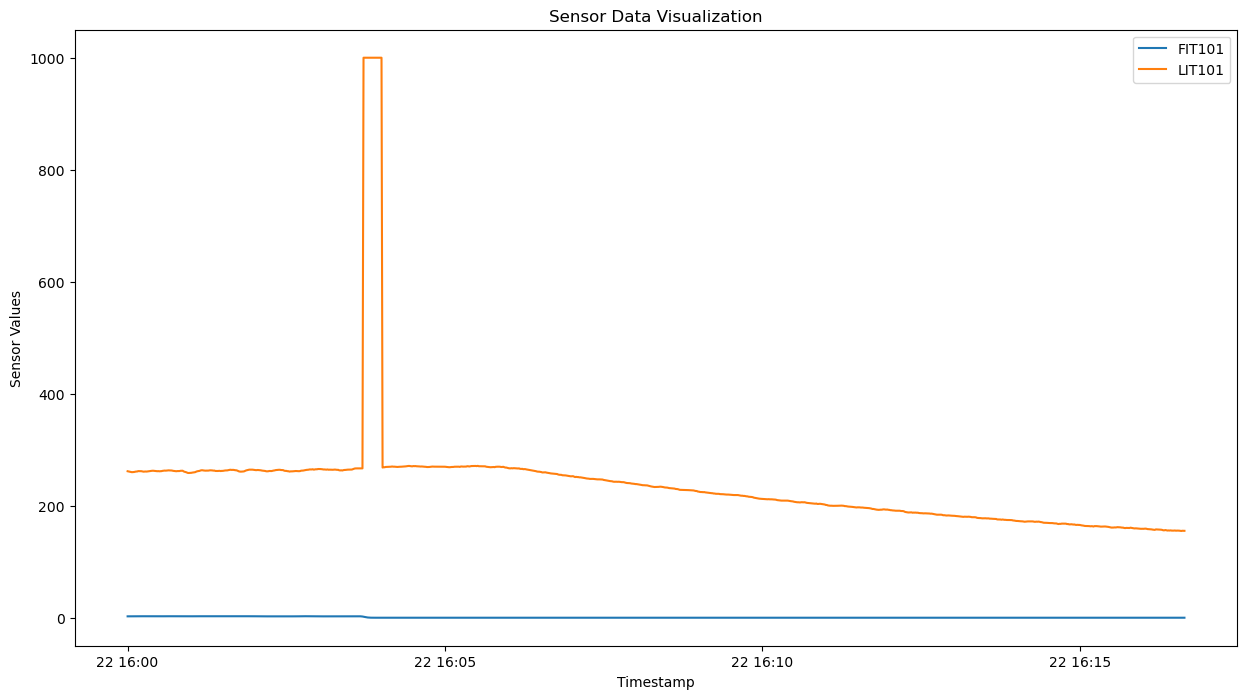

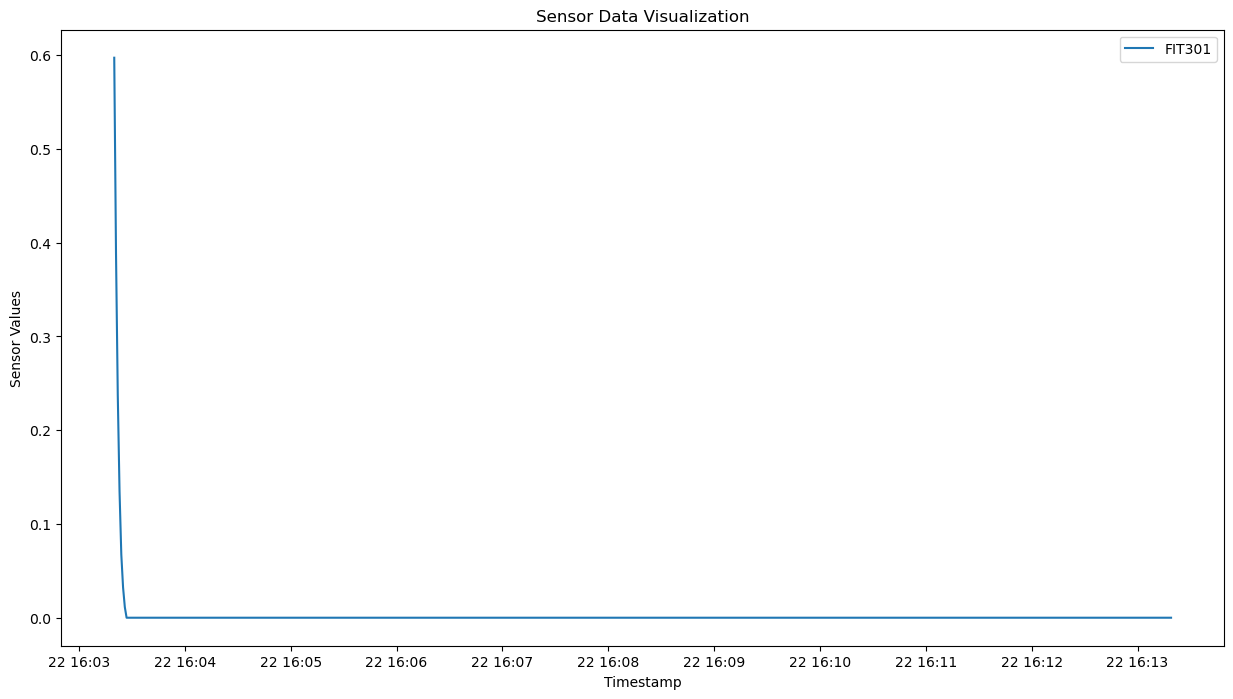

In [11]:
def visualize_sensor_data(df: pd.DataFrame, window: (int, int) = None, sensors: list[str] = None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
#visualize_sensor_data(train_data)

Below are the implementations for DTW and PCA functions

In [12]:
def dynamic_time_warping(a: np.ndarray, b: np.ndarray):
    n = len(a)
    m = len(b)

    dist = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            dist[i][j] = (b[j]-a[i])**2
    for i in range(1,n):
        dist[i][0] += dist[i-1][0]
    for j in range(1,m):
        dist[0][j] += dist[0][j-1]
    for i in range(1,n):
        for j in range(1,m):
            dist[i][j] += min(dist[i-1][j-1], dist[i-1][j], dist[i][j-1])

    return np.sqrt(dist[n-1][m-1])

In [13]:
def norm(X: np.ndarray) -> np.ndarray:
    return X - np.mean(X, axis=0)

def principal_component_analysis(df: pd.DataFrame, k: int) -> np.ndarray:
    X = norm(np.array(df))
    _, evecs = np.linalg.eigh(np.cov(X.T))
    return evecs[:, :-k:-1]

def apply_principal_component_analysis(df: pd.DataFrame, eigenvectors: np.ndarray) -> pd.DataFrame:
    return pd.DataFrame(norm(np.array(df)) @ eigenvectors)

Compute PCA to the train data and apply it to test data.

First we load the test data and copy it. We do the same for the training data. We drop both the column with timestamps and the column with the label ('Normal/Attack').

In [14]:
# copy the training data and remove the timestamp and "normal/attack" columns
copy_train_data = train_data.drop(columns=['Timestamp', 'Normal/Attack'])

# copy test data and do the same
test_file_path = 'lab1_test.csv'

test_data: pd.DataFrame = pd.read_csv(test_file_path, delimiter=',')

copy_test_data = test_data.drop(columns=['Timestamp', 'Normal/Attack'])

*PCA-based Anomaly Detection*

Here we calculate the PCA on the training data and then apply it to the testing data. We calculate residuals for 51 different k's, k=1 up to k=51. This is the case because the data has 51 different features. We add all the residuals to get an overall view of where abnormalities occur for the different residual plots. We see that around the data index point 250000, the largest abnormalities happen.

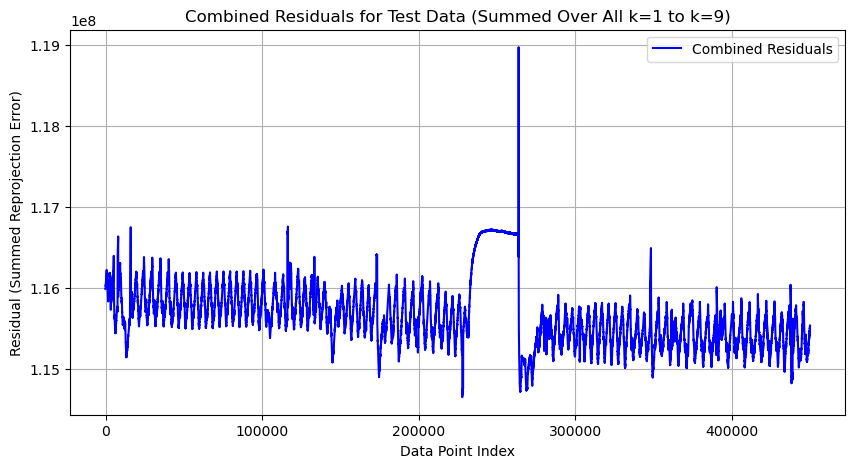

In [15]:
# a method to undo normalization
def undo_normalization(matrix):
    return matrix + np.mean(matrix, axis=0)

# Initialize a placeholder for the combined residuals
combined_residuals_test = np.zeros(copy_test_data.shape[0])

for k1 in range(1,52):
    # the following normalizes the data, creates covariance matrix and calculates it's eigenvectors and values
    # then it orders them based on eigenvalue (descending) and picks the first k
    eigenvectors_test = principal_component_analysis(copy_train_data, k1)

    # now we project the raw data onto component space
    projected_data_test = apply_principal_component_analysis(copy_test_data, eigenvectors_test)

    # to perform anomaly detection with PCA we also need to reproject this data from component space back into the original feature space
    # since the matrix of eigenvectors has property that its transpose is it's inverse, we can simply multiply the matrix called 
    # "projected_data" with the transpose of the matrix called "eigenvectors"
    reprojected_data_test = projected_data_test.to_numpy() @ np.transpose(eigenvectors_test)

    # now we calculate the "reprojection error" with residuals, we use euclidean distance
    # np.linalg.norm computes the L2 norm (Euclidean distance) row-wise
    # we need to undo the normalization
    residual_test = np.linalg.norm(copy_test_data - undo_normalization(reprojected_data_test), axis=1)**2

    # Add the residuals for this k to the combined residuals
    combined_residuals_test += residual_test

# Plot the combined residuals
plt.figure(figsize=(10, 5))
plt.plot(combined_residuals_test, label='Combined Residuals', color='blue')
plt.title("Combined Residuals for Test Data (Summed Over All k=1 to k=9)")
plt.xlabel('Data Point Index')
plt.ylabel('Residual (Summed Reprojection Error)')
plt.legend()
plt.grid(True)
plt.show()


*PCA calculated on training data and applied to training data*

We need to choose a k (representing the number of eigenvectors/principal components to us in reprojection) to work with in our PCA calculations. We want to have a smaller k for the purpose of dimensionality reduction, but smaller k means that we will have a worse reprojection and therefore higher residual values. We need to keep this in mind.
To make the choice of k, we make a so called elbow-plot. We plot values k against the total sum of residuals over all their data points. This way we can decide a value k, while looking at the quality of the reprojection that is represented by the magnitude of sum of residuals.

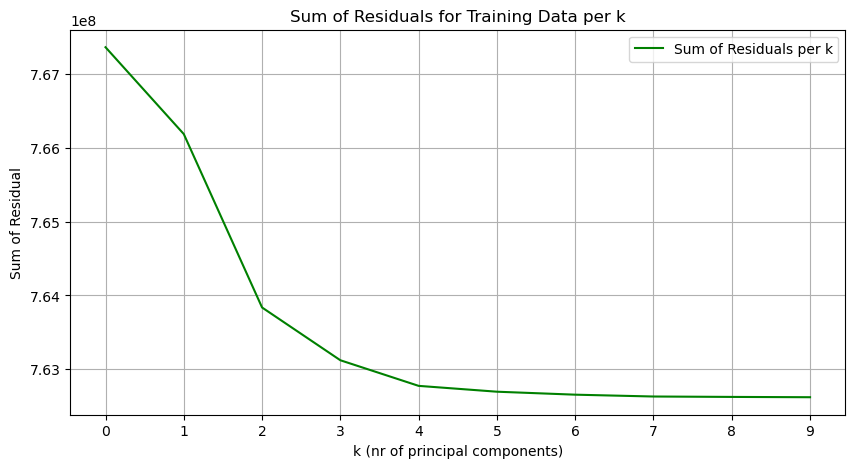

In [16]:
combined_residuals = np.zeros(copy_train_data.shape[0])
residual_sum_per_k = []

# k=1 up to k=10
for k2 in range(1,11):
    eigenvectors_k2 = principal_component_analysis(copy_train_data, k2)
    projected_data_k2 = apply_principal_component_analysis(copy_train_data, eigenvectors_k2)
    reprojected_data_k2 = projected_data_k2.to_numpy() @ np.transpose(eigenvectors_k2)
    residuals_k2 = np.linalg.norm(copy_train_data - undo_normalization(reprojected_data_k2), axis=1)
    residual_sum_per_k.append(np.sum(residuals_k2))

# Plot the sum of all residuals per nr of principal components k
plt.figure(figsize=(10, 5))
plt.plot(residual_sum_per_k, label='Sum of Residuals per k', color='green')
plt.title("Sum of Residuals for Training Data per k")
plt.xlabel('k (nr of principal components)')
plt.ylabel('Sum of Residual')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 10)) 
plt.show()

We see from this plot that after k=2, the decrease in sum of residuals seems to keep decreasing more and more. We want to represent the training data with the least amount of components k as possible, while still having a somewhat accurate reprojection. Because of this we choose our value k=2. From k=2 onwards, the decrease in residual is very little compared to previous decreases.

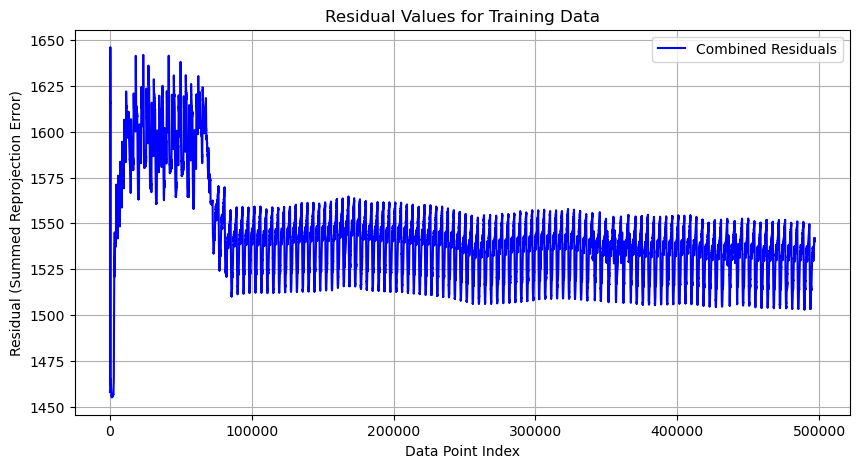

In [17]:
# choose a k3
k3 = 2

eigenvectors = principal_component_analysis(copy_train_data, k3)
projected_data = apply_principal_component_analysis(copy_train_data, eigenvectors)
reprojected_data = projected_data.to_numpy() @ np.transpose(eigenvectors)
residuals = np.linalg.norm(copy_train_data - undo_normalization(reprojected_data), axis=1)
    
# Plot the combined residuals against the data points
plt.figure(figsize=(10, 5))
plt.plot(residuals, label='Combined Residuals', color='blue')
plt.title("Residual Values for Training Data")
plt.xlabel('Data Point Index')
plt.ylabel('Residual (Summed Reprojection Error)')
plt.legend()
plt.grid(True)
plt.show()


We can mainly see "abnormalities" at the first group of data points (the top rows of the data matrix). Abnormality means there is a relatively larger difference between the raw data and their projection when comparing to other data points.

Why would these values be higher around this area?
-> These residual values at the start could be higher than the rest because of the fact that the first couple of data points are anomalous. Maybe because something went wrong with data collection or possibly because of the fact that the first group of data just has different characteristics.

*Removing Abnormalities*

Since we only want to model normal behavior, we will remove the abnormalities. To do so we will compute the mean and standard deviation of the combined residual-plot. We then consider points that lie above a certain number of standard deviations (x) as anomalies, this is our treshold. We choose x=1 as the number of standard deviations to detect anomalous points.

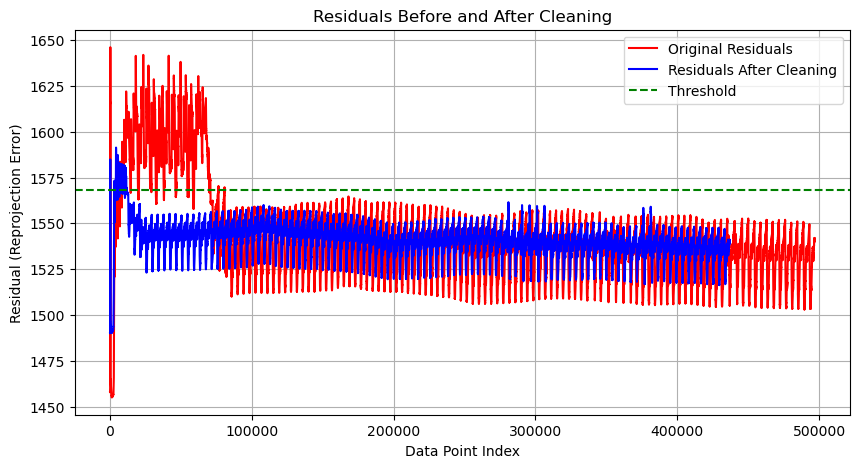

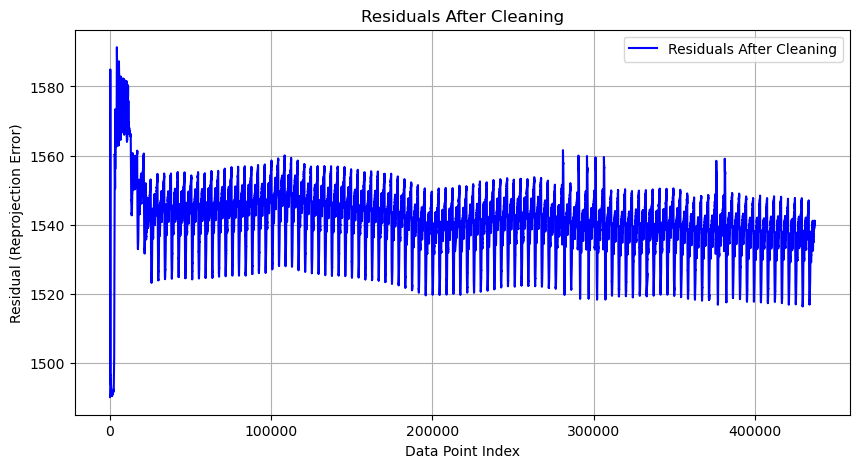

In [18]:
# we choose x=1 as number of standard deviations to detect anomalies
x = 1
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
threshold = mean_residual + x * std_residual

# Identify normal points (residuals below the threshold)
normal_indices = residuals < threshold

# Filter out abnormal points
cleaned_train_data = copy_train_data[normal_indices]

# Recompute PCA on the cleaned data
eigenvectors_cleaned = principal_component_analysis(cleaned_train_data, k3)
projected_data_cleaned = apply_principal_component_analysis(cleaned_train_data, eigenvectors_cleaned)
reprojected_data_cleaned = projected_data_cleaned.to_numpy() @ np.transpose(eigenvectors_cleaned)

# Plot the residuals for the cleaned data
residuals_cleaned = np.linalg.norm(cleaned_train_data - undo_normalization(reprojected_data_cleaned), axis=1)

# Plot residuals before and after cleaning
plt.figure(figsize=(10, 5))
plt.plot(residuals, label='Original Residuals', color='red')
plt.plot(residuals_cleaned, label='Residuals After Cleaning', color='blue')
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')
plt.title("Residuals Before and After Cleaning")
plt.xlabel("Data Point Index")
plt.ylabel("Residual (Reprojection Error)")
plt.legend()
plt.grid(True)
plt.show()

# Now only the cleaned residuals
plt.figure(figsize=(10, 5))
plt.plot(residuals_cleaned, label='Residuals After Cleaning', color='blue')
plt.title("Residuals After Cleaning")
plt.xlabel("Data Point Index")
plt.ylabel("Residual (Reprojection Error)")
plt.legend()
plt.grid(True)
plt.show()

We chose x=1 (nr of standard deviations), since the residuals deviate with a rather consistent magnitude except for at the start. This way we expected to be able to elminate most/almost all of these anomalous points. We see that the treshold in the graph "Residuals Before and After Cleaning" clearly shows which old anomalous values are elminated.